In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded=files.upload()

Saving Bengaluru_House_Data.csv to Bengaluru_House_Data.csv


In [ ]:
home=pd.read_csv(r"/content/Bengaluru_House_Data.csv")

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
import sklearn
import xgboost

In [ ]:

home.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [ ]:
#removing NaN values from the dataset
home.dropna(inplace =True)

In [ ]:
home = home.drop(columns='society')

In [ ]:
home.reset_index(drop= True, inplace =True)

In [ ]:
home['bhk'] = home['size'].str.split().str[0]
home['bhk'].dropna(inplace = True)
home['bhk'] = home['bhk'].astype('int')

In [ ]:
print(home['total_sqft'].iloc[[17]])

## fucntion to remove 2100 - 2850 by taking there average
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

17    2100 - 2850
Name: total_sqft, dtype: object


In [ ]:
## applying the fucntion to the column: - 'total_sqft'
home.total_sqft = home.total_sqft.apply(convert_sqft_to_num)
# Taking only the Numeric values from the data and storing it in 'home'
home = home[home.total_sqft.notnull()]
# display the first 2 columns from the dataset
home.head(2)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4


In [ ]:

home = home[~(home.total_sqft/home.bhk<200)]
home.shape

(7478, 9)

In [ ]:
## dividing the dataset into Continous and Categorical variables:
cont_ = home.select_dtypes(exclude = 'object')
cat_ = home.select_dtypes(include  = 'object')

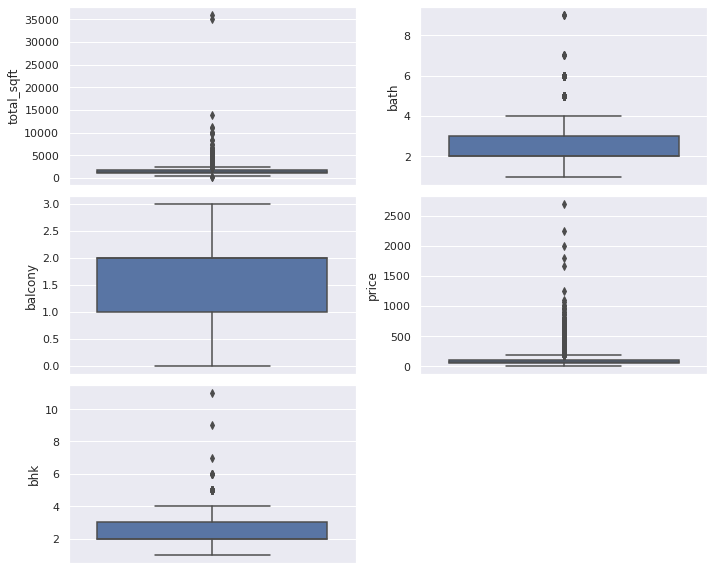

In [ ]:
## displaying only the continous variables from the dataset
## to determine the variables which have outliers and those which needs to be removed
fig = plt.figure(figsize = (10,8))
for index,col in enumerate(cont_):
    plt.subplot(3,2,index+1)
    sns.boxplot(y = cont_.loc[:,col])
fig.tight_layout(pad = 1.0)

In [ ]:
home = home.drop(home[home['bath']>6].index)
home = home.drop(home[home['bhk']>7.0].index)

In [ ]:
## Feature Engineering step
home['price_per_sqft'] = home['price']*100000/home['total_sqft']
home.head()


,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
3,Super built-up Area,Ready To Move,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,3247.863248
4,Plot Area,Ready To Move,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,10592.459605


In [ ]:
home['price_per_sqft'].describe()

count     7471.000000
mean      5853.051952
std       2720.468727
min        371.428571
25%       4277.681409
50%       5315.315315
75%       6693.387739
max      76530.612245
Name: price_per_sqft, dtype: float64

In [ ]:
## taking only the values with 1st Standard devaition values.
## as per Normal Distribution, 95% of our data lies within 1st Standard Deviation as per the location

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
home = remove_pps_outliers(home)
home.shape

(5389, 10)

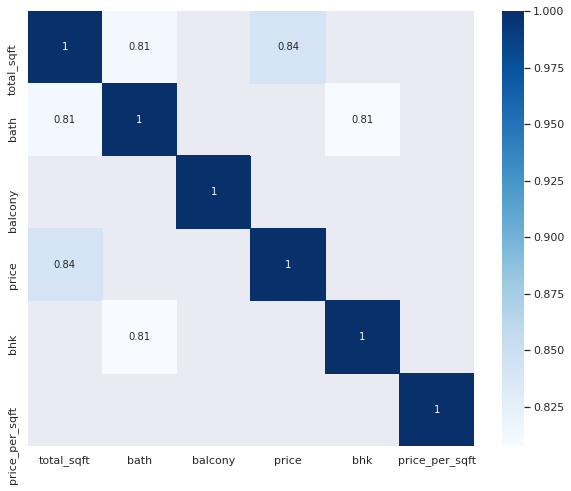

In [ ]:
## finding correlation values within the dataset
## we remove features which are highly related to each other as they do not provide
## any significance value to our Model

corr = home.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr,mask = corr<0.8 ,annot= True,cmap = 'Blues')

In [ ]:
## checking the dataset with highest location data provided
## because having values for a location less than 10 wont give us good information on the dataset

home.location = home.location.str.strip()
location_stats = home['location'].value_counts(ascending=False)
location_stats

Whitefield         357
Sarjapur  Road     240
Electronic City    225
Kanakpura Road     157
Thanisandra        141
                  ... 
Janatha Colony       1
Hiremath Layout      1
Vimanapura           1
Gulimangala          1
Ashwini layout       1
Name: location, Length: 430, dtype: int64

In [ ]:
## cretaing a Series of all the location having less than 10 entries against its  
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Bommenahalli          10
Neeladri Nagar        10
5th Phase JP Nagar    10
Munnekollal           10
Gubbalala             10
                      ..
Janatha Colony         1
Hiremath Layout        1
Vimanapura             1
Gulimangala            1
Ashwini layout         1
Name: location, Length: 319, dtype: int64

In [ ]:
## using lambda function to naming 'location_stats_less_than_10' as 'other' and then removing it

home.location = home.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

home = home[home.location != 'other']

In [ ]:
## Keeping in mind that the number of Bathroom shouldn't be more than BHK+2
## Example for a 3 bhk, the number of bathrooms shouldn't be more than 5

home = home[home.bath<home.bhk+2]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


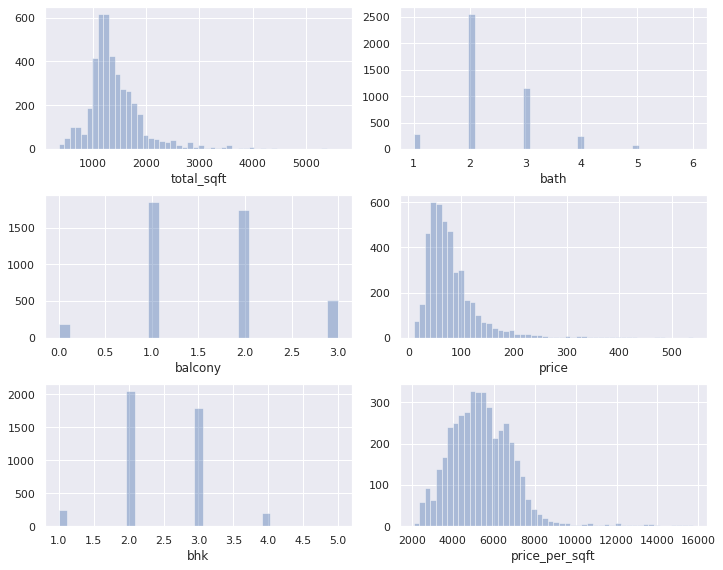

In [ ]:
## representing Numerical Data and Visualizing the same usin Distplot to gain further info

num_ = home.select_dtypes(exclude = 'object')
fig = plt.figure(figsize =(10,8))
for index, col in enumerate(num_):
    plt.subplot(3,2,index+1)
    sns.distplot(num_.loc[:,col],kde = False)
fig.tight_layout(pad = 1.0)

In [ ]:
## performing One hot encoding on the Categorical values
## 1st step. create dummies
dummies = pd.get_dummies(home.location)
dummies.head(3)

,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Ardendale,Attibele,BTM 2nd Stage,Balagere,Banashankari,Bannerghatta Road,Begur,Begur Road,Bellandur,Bhoganhalli,Binny Pete,Bisuvanahalli,Bommasandra,Brookefield,Budigere,CV Raman Nagar,Chandapura,Channasandra,Choodasandra,Devanahalli,Doddathoguru,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,Gottigere,Green Glen Layout,Gunjur,HSR Layout,Haralur Road,Harlur,Hebbal,...,Kodichikkanahalli,Koramangala,Kothanur,Kudlu,Kudlu Gate,Kundalahalli,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Malleshwaram,Marathahalli,Mysore Road,Old Airport Road,Old Madras Road,Panathur,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Ramagondanahalli,Ramamurthy Nagar,Sahakara Nagar,Sarjapur,Sarjapur Road,Somasundara Palya,Sonnenahalli,Subramanyapura,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
## adding the dummies dataframe to our main DataFrame

home = pd.concat([home,dummies],axis='columns')

## removing 'location' as we have already created the dummies
home1 = home.drop('location',axis = 1)

## removing columns which will not be required by our model
home1 = home1.drop(columns=['balcony','price_per_sqft'])
home1

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Ardendale,Attibele,BTM 2nd Stage,Balagere,Banashankari,Bannerghatta Road,Begur,Begur Road,Bellandur,Bhoganhalli,Binny Pete,Bisuvanahalli,Bommasandra,Brookefield,Budigere,CV Raman Nagar,Chandapura,Channasandra,Choodasandra,Devanahalli,Doddathoguru,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,Gottigere,Green Glen Layout,Gunjur,...,Kodichikkanahalli,Koramangala,Kothanur,Kudlu,Kudlu Gate,Kundalahalli,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Malleshwaram,Marathahalli,Mysore Road,Old Airport Road,Old Madras Road,Panathur,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Ramagondanahalli,Ramamurthy Nagar,Sahakara Nagar,Sarjapur,Sarjapur Road,Somasundara Palya,Sonnenahalli,Subramanyapura,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
8,550.0,1.0,27.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,440.0,1.0,28.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,510.0,1.0,25.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11,510.0,1.0,25.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
44,1080.0,2.0,72.00,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5384,1169.0,2.0,64.08,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5385,2500.0,3.0,138.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5386,1160.0,2.0,64.08,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5387,2503.0,3.0,138.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
home1.reset_index(drop = True)

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Ardendale,Attibele,BTM 2nd Stage,Balagere,Banashankari,Bannerghatta Road,Begur,Begur Road,Bellandur,Bhoganhalli,Binny Pete,Bisuvanahalli,Bommasandra,Brookefield,Budigere,CV Raman Nagar,Chandapura,Channasandra,Choodasandra,Devanahalli,Doddathoguru,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,Gottigere,Green Glen Layout,Gunjur,...,Kodichikkanahalli,Koramangala,Kothanur,Kudlu,Kudlu Gate,Kundalahalli,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Malleshwaram,Marathahalli,Mysore Road,Old Airport Road,Old Madras Road,Panathur,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Ramagondanahalli,Ramamurthy Nagar,Sahakara Nagar,Sarjapur,Sarjapur Road,Somasundara Palya,Sonnenahalli,Subramanyapura,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,550.0,1.0,27.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,440.0,1.0,28.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,510.0,1.0,25.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,510.0,1.0,25.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1080.0,2.0,72.00,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,1169.0,2.0,64.08,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4299,2500.0,3.0,138.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4300,1160.0,2.0,64.08,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4301,2503.0,3.0,138.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
## Dividing our dataset to Independent and Dependent Variables

X = home1.drop('price',axis = 1).values ## Independent Variables
y = home1.price.values ## Dependent Variables

In [ ]:
## adding a new axis
y = y[:,np.newaxis]

In [ ]:
## preprocessing the data values to StandardScaler
sc = preprocessing.StandardScaler()
X1 = sc.fit_transform(X)
## Standardize a dataset along any axis

## Center to the mean and component wise scale to unit variance.

Std_x1 = preprocessing.scale(X)

In [ ]:
## importing the required libraries for Machine Learning

from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.model_selection import cross_validate as CV


In [ ]:
## using Cross Validation of 5 andscoring of Negative mean sqaured error

cross1 = cross_val_score(lr,Std_x1,y,cv=5,scoring='neg_mean_squared_error')
print(cross1.mean())

-1.3941909779463986e+30


In [ ]:
# from the model selection module import train_test_split for the ML training and testing.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.3,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(rscore)

0.8994980116600451
